# Zonal Statistics with ASTER and MODIS Thermal Infrared Radiance Imagery

In [1]:
# xarray family of packages for working with raster data
import xarray as xr
import xrspatial as xrs
import rioxarray

# aster and modis functions for unit conversion of digital number to radiance and brightness temperature
import aster_utils 
import modis_utils

# our favorite python packages for arrays, data frames, and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


---
**Open and clean-up input datasets**

Use rioxarray to open a GeoTIFF of MODIS Radiance

In [2]:
modis_rad_filepath = '/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A2017111.1850.061.2017314062948.tif'
modis_ds = xr.open_rasterio(modis_rad_filepath)

Open the coincident ASTER thermal infrared radiance GeoTIFF image we want to compare with

In [3]:
aster_rad_filepath = '/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00304212017185107_20170422082541_26960_ImageData14.tif'
aster_src = xr.open_rasterio(aster_rad_filepath)

Define a working area her in local UTM coordinates to clip all three rasters to the same common area

In [4]:
utm_northings_max = 4205000
utm_northings_min = 4185000
utm_eastings_max = 305000
utm_eastings_min = 285000

geometry = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_eastings_min, utm_northings_max],
            [utm_eastings_max, utm_northings_max],
            [utm_eastings_max, utm_northings_min],
            [utm_eastings_min, utm_northings_min]
        ]]
    }
]

Clean up the ASTER image by replacing nodata values with NaN, removing an extra dimension, converting the digital number values to radiance values, and finally clipping to the geometry defined above.

In [5]:
# Replace the nodatavals with NaN, squeeze out the band dim we don't need
aster_src = aster_src.where(aster_src!=aster_src.nodatavals, np.nan).squeeze()
# Convert ASTER DN to Radiance
aster_band = 14
aster_rad = aster_utils.tir_dn2rad(aster_src, aster_band)
# set crs back
aster_rad.rio.set_crs(aster_src.crs, inplace=True)
# clip to geometry
aster_rad_clipped = aster_rad.rio.clip(geometry).rename('aster_rad')

Use reproject_match to align the MODIS radiance & zones raster to the ASTER image, clip to the geometry defined above.

In [6]:
# convert from DN to Radiance and Brightness Temperature
modis_rad_tb = modis_utils.emissive_convert_dn(modis_ds)
# Select a single band from the MODIS dataset
# make sure to use MODIS band 31 (here index 10, it is around 11 microns)
# See a list of band numbers with: modis_ds_repr_match.band_names.split(',')
modis_band_index = 10
modis_rad_tb_single_band = modis_rad_tb.isel(band=modis_band_index)
# Create "zone_labels" by numbering each MODIS pixel
n_rows, n_cols = modis_rad_tb_single_band.radiance.shape
modis_rad_tb_single_band['modis_zones'] = (('y', 'x'), np.reshape(np.arange(n_rows*n_cols), (n_rows, n_cols)))
# Change datatype to float, this is requried for reproject match apparently (?) change back to int later
modis_rad_tb_single_band['modis_zones'] = modis_rad_tb_single_band.modis_zones.astype('float32')
# Add CRS info to this new "modis_zones" data array by copying over attributes from another data array
zones_attrs = modis_rad_tb_single_band.radiance.attrs.copy()
# edit long name attribute for modis zones data array
zones_attrs['long_name'] = 'modis_zone_labels'
# Add the attributes
modis_rad_tb_single_band.modis_zones.attrs = zones_attrs
## use Reproject_Match to reproject the GOES geotiff into the same CRS as the ASTER geotiff
modis_rad_tb_single_band_repr_match = modis_rad_tb_single_band.rio.reproject_match(aster_src)
# clip out anything that is nan in the ASTER image
modis_rad_tb_single_band_repr_match = modis_rad_tb_single_band_repr_match.where(np.isnan(aster_src.values) == False)
## set crs
#modis_ds_repr_match.rio.set_crs(aster_src.crs, inplace=True)
# clip to geometry
modis_rad_tb_single_band_repr_match = modis_rad_tb_single_band_repr_match.rio.clip(geometry)
# remove nodata value
modis_repr = modis_rad_tb_single_band_repr_match.where(modis_rad_tb_single_band_repr_match.tb_c != modis_rad_tb_single_band_repr_match.tb_c._FillValue)
# scale the modis zones by the minimum zone value now that we've clipped to a smaller area and have much fewer zones
# switch back to int64 datatype
modis_repr['modis_zones'] = (modis_repr.modis_zones - modis_repr.modis_zones.min()).astype('int')
# Where we had NaN values, these overflowed to -9223372036854775808 when we turned them into ints,
# set these values to a nodata value of -9999 which we can ignore later
modis_repr['modis_zones'] = modis_repr.modis_zones.where(modis_repr.modis_zones != -9223372036854775808, -9999)
# drop extra coords
modis_repr = modis_repr.drop(['band','spatial_ref'])
#########   

Plot each of these images:

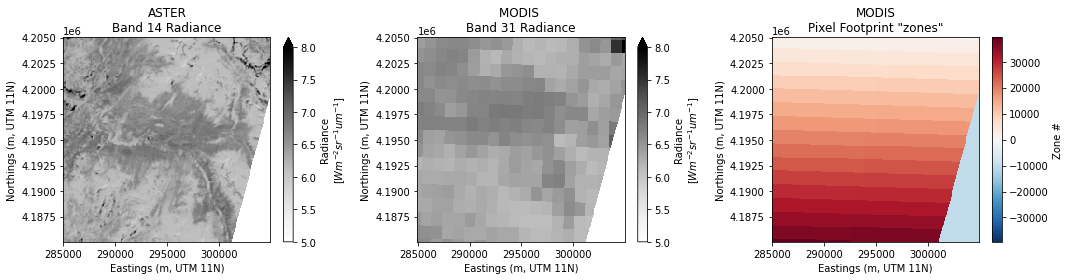

In [7]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1,ncols=3, figsize=(15,4), tight_layout=True)

aster_rad_clipped.plot(ax=ax1, cmap='Greys', vmin=5, vmax=8, cbar_kwargs={'label': 'Radiance\n[$W m^{-2} sr^{-1} um^{-1}$]'})
ax1.set_title('ASTER\nBand 14 Radiance')

modis_repr.radiance.plot(ax=ax2, cmap='Greys', vmin=5, vmax=8, cbar_kwargs={'label': 'Radiance\n[$W m^{-2} sr^{-1} um^{-1}$]'})
ax2.set_title('MODIS \nBand 31 Radiance')

modis_repr.modis_zones.plot(ax=ax3, cbar_kwargs={'label': 'Zone #'})
ax3.set_title('MODIS\nPixel Footprint "zones"')

for this_ax in [ax1, ax2, ax3]:
    this_ax.set_ylabel('Northings (m, UTM 11N)')
    this_ax.set_xlabel('Eastings (m, UTM 11N)')

---
**Compute zonal statistics and format results**

Compute zonal statistics from the ASTER image, using the MODIS zone labels:

In [8]:
zonalstats = xrs.zonal.stats(modis_repr.modis_zones, 
                             aster_rad_clipped, 
                             stat_funcs=['mean', 'max', 'min', 'std', 'var', 'count'])

# Preview the resulting dataframe
zonalstats.head()

,mean,max,min,std,var,count
-9999,--,--,--,--,--,0
1,6.11499,6.34837,5.88335,0.104137,0.0108444,12
2,6.19685,6.4163,6.0819,0.0840146,0.00705845,11
3,6.1655,6.51035,6.09235,0.112238,0.0125973,14
4,6.36557,7.5449,6.07145,0.415323,0.172493,24


In [9]:
# Convert zonal statistics dataframe to xarray dataset
zonalstats = xr.Dataset(zonalstats)

# Preview the dataset
zonalstats

<xarray.Dataset>
Dimensions:  (dim_0: 298)
Coordinates:
  * dim_0    (dim_0) int64 -9999 1 2 3 4 5 ... 39368 39369 39370 39371 39372
Data variables:
    mean     (dim_0) object -- 6.115 6.197 6.165 ... 6.522 6.217 6.391 6.416
    max      (dim_0) object -- 6.348 6.416 6.51 ... 6.636 6.395 6.934 6.636
    min      (dim_0) object -- 5.883 6.082 6.092 ... 6.39 6.082 6.124 6.239
    std      (dim_0) object -- 0.1041 0.08401 0.1122 ... 0.1041 0.198 0.1059
    var      (dim_0) object -- 0.01084 0.007058 ... 0.01084 0.0392 0.01122
    count    (dim_0) object 0 12.0 11.0 14.0 24.0 ... 22.0 22.0 12.0 12.0 11.0

Define a function to map the results from xrs.zonal.stats() back into the original zones grid

In [10]:
def mapZonalStats(zones, zonalstats, stat_name):
    ''' Function for mapping the zonal statistics back to the original grid to get a 2D map of the chosen statistic'''
    # create an empty array for this summary stat
    zonal_stat = np.zeros_like(zones.values, dtype=np.float64)

    # for each zone
    for zone_n in zonalstats.dim_0.values:
        # get the summary stat for that zone, 
        # and assign it to the correct locations in the zonal_stat array
        try:
            zonal_stat[zones.values==zone_n] = zonalstats['{}'.format(stat_name)].sel(dim_0=zone_n).values
        except: #MaskError: Cannot convert masked element to a Python int.
            zonal_stat[zones.values==zone_n] = -9999

    # convert this to an xarray data array with the proper name
    zonal_stat_da = xr.DataArray(zonal_stat, 
                                 dims=["y", "x"],
                                 coords=dict(
                                             x=(["x"], zones.x),
                                             y=(["y"], zones.y),
                                             ),
                                 name='zonal_{}'.format(stat_name))
    # remove nodata values
    zonal_stat_da = zonal_stat_da.where(zonal_stat_da!=-9999, np.nan)

    return zonal_stat_da

In [11]:
# Map each zonal stat back into the original zones grid
zonal_means = mapZonalStats(modis_repr.modis_zones, zonalstats, 'mean').rename('mean_rad')
zonal_max = mapZonalStats(modis_repr.modis_zones, zonalstats, 'max').rename('max_rad')
zonal_min = mapZonalStats(modis_repr.modis_zones, zonalstats, 'min').rename('min_rad')
zonal_std = mapZonalStats(modis_repr.modis_zones, zonalstats, 'std').rename('std_rad')
zonal_var = mapZonalStats(modis_repr.modis_zones, zonalstats, 'var').rename('var_rad')
zonal_count = mapZonalStats(modis_repr.modis_zones, zonalstats, 'count')

In [12]:
### Compute brightness temperatures for the original ASTER image, and each zonal statistic from Radiance
rad2tb_stats = []
for this_stat_da in [aster_rad_clipped, zonal_means, zonal_max, zonal_min, zonal_std, zonal_var]:
    # ASTER Radiance to Brightness Temperature
    aster_this_stat_da_tb_K =  aster_utils.tir_rad2tb(this_stat_da, aster_band)
    aster_this_stat_da_tb_K.rio.set_crs(aster_src.crs, inplace=True)
    aster_this_stat_da_tb_K = aster_this_stat_da_tb_K.rename('{}2tbK'.format(this_stat_da.name))
    rad2tb_stats.append(aster_this_stat_da_tb_K)
    # convert brightness temperature in K to C
    #aster_this_stat_da_tb_C = aster_this_stat_da_tb_K.values - 273.15
    #aster_this_stat_da_tb_C = xr.DataArray(aster_this_stat_da_tb_C, name='{}2tbC'.format(this_stat_da.name))
    #rad2tb_stats.append(aster_this_stat_da_tb_C)

Merge all zonal stats back with the original ASTER data to create a single dataset

In [13]:
# Merge all the zonal statistics data arrays and the mean difference data array
ds = xr.merge([aster_rad_clipped, modis_repr, zonal_means, zonal_max, zonal_min, zonal_std, zonal_var, zonal_count] + rad2tb_stats)
# Clip this dataset to the ASTER image extent
ds = ds.where(~np.isnan(aster_rad_clipped))

Compute the difference between MODIS and ASTER zonal mean Radiance, and Brightness Temperature

In [14]:
# Compute the difference between MODIS Radiance and the ASTER zonal mean radiance
mean_diff_rad = modis_repr.radiance.values - ds.mean_rad.values
# Create a data array for the mean difference values
mean_diff_rad_da = xr.DataArray(mean_diff_rad, name='mean_diff_rad', dims=["y", "x"])

# Compute the difference between MODIS brightness temperature and the ASTER zonal mean brightness temperature
mean_diff_tb = modis_repr.tb.values - ds.mean_rad2tbK.values
# Create a data array for the mean difference values
mean_diff_tb_da = xr.DataArray(mean_diff_tb, name='mean_diff_tb', dims=["y", "x"])


# Add both of these to our dataset
ds['mean_diff_rad'] = mean_diff_rad_da
ds['mean_diff_tb'] = mean_diff_tb_da

Remove data where we have overlap between a MODIS pixel footprint "zone" and the edge of the ASTER image


In [15]:
# Remove data where we have overlap between a MODIS pixel footprint "zone" and the edge of the ASTER image
# Use the "zonal_count" (the number of ASTER pixels in each MODIS pixel footprint) to determine this
# Example: ~123 90m ASTER pixels is 123x90x90 square meters, or approximately 1 square kilometer or,
# about 1x1 km, about the size of a full MODIS pixel here
# NOTE: The actual size of MODIS pixels varies, starting at 1km at nadir and increasing towards the edge of the image
# To remove edge pixels, we can remove pixels in containing less than the lower 5%th quantile of ASTER subpixels
#ds.zonal_count.plot.hist(bins=100); # plot to show a histogram
#plt.axvline(ds.zonal_count.quantile(.05),c='r'); # plot to show the 5%th quantile cutoff
print('Removing MODIS pixels containing fewer than {} ASTER pixels'.format(ds.zonal_count.quantile(.05).values))
ds = ds.where(ds.zonal_count > ds.zonal_count.quantile(.05))

Removing MODIS pixels containing fewer than 134.0 ASTER pixels


Plot all the results:

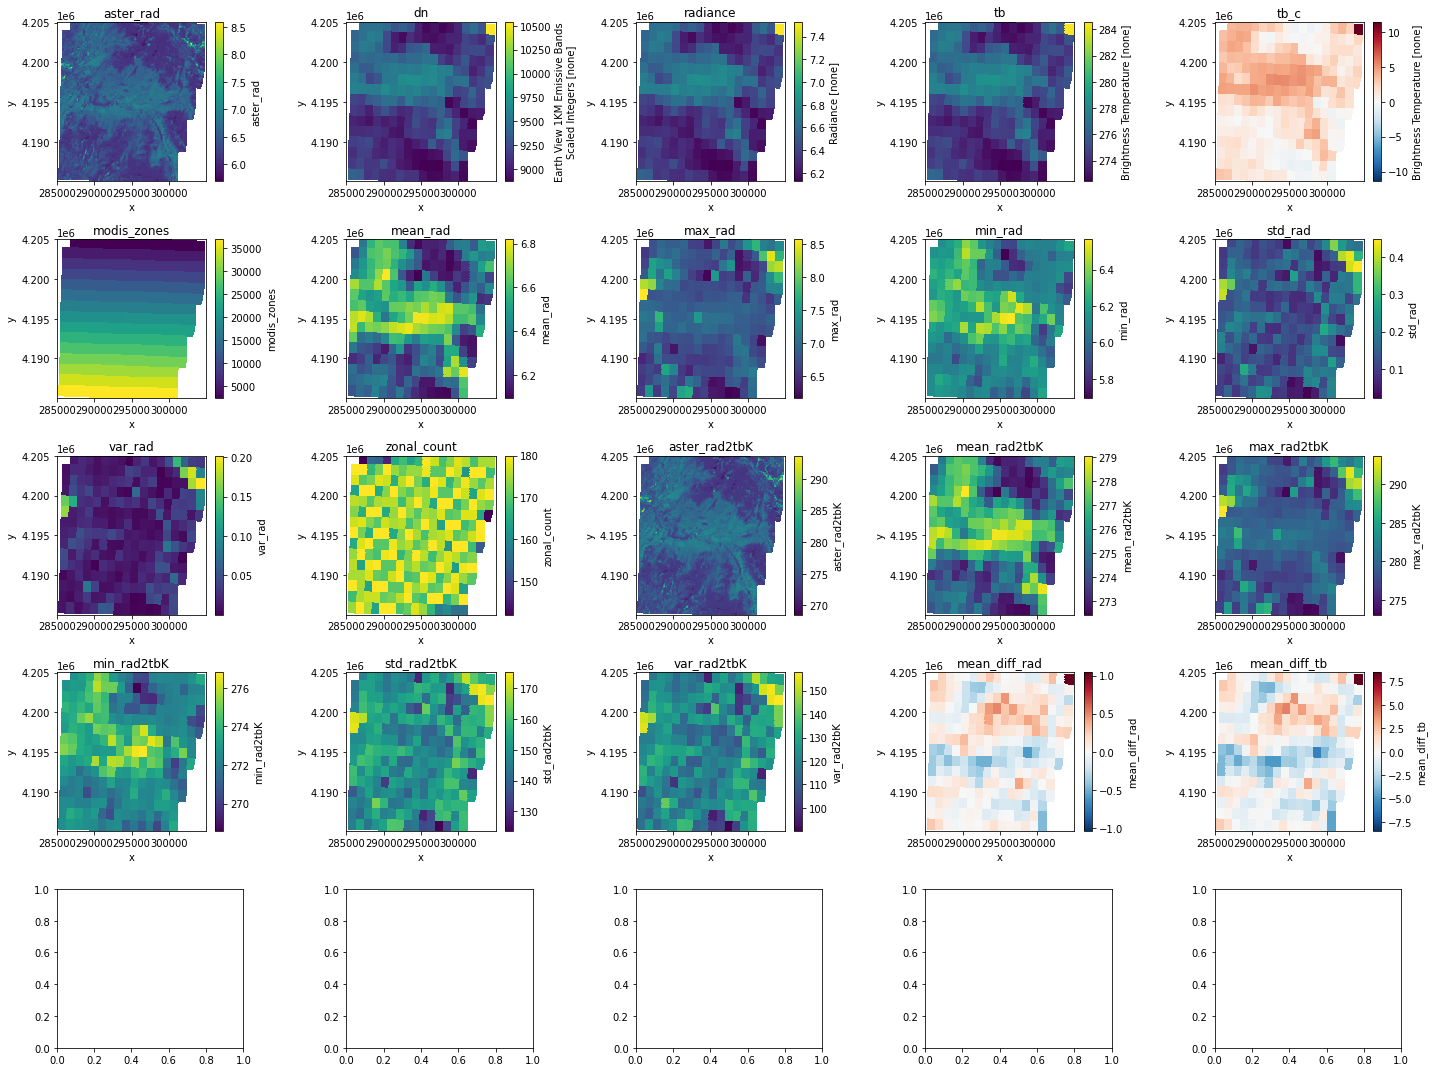

In [16]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20,15), tight_layout=True)
ax = ax.flatten()

for i, data_var in enumerate(ds):
    ds[str(data_var)].plot(ax=ax[i])
    ax[i].set_title(str(data_var))

---

**Wrap the above into a function**

In [17]:
def upscale_aster_modis_rad_zonal_stats(aster_rad_filepath, modis_rad_filepath, bounding_geometry, modis_band_index=10, zonal_count_quantile_threshold=0.05, output_filepath=None):
    '''Given an ASTER thermal infrared radiance GeoTiff image, and a MODIS MxD021KM Radiance GeoTiff image,
       compute zonal statistics for each MODIS pixel footprint. Compute the difference between MODIS radiance
       and ASTER zonal mean radiance.
       Return a dataset, or save dataset to a netcdf file, with the input dataarrays plus all the zonal
       statistic data arrays.'''
    
    ### Open and clean-up input datasets ###
    
    # Open the ASTER thermal infrared radiance GeoTIFF image we want to compare MODIS with
    aster_src = xr.open_rasterio(aster_rad_filepath)
    
    # Clean up the ASTER image by replacing nodata values with NaN, removing an extra dimension, converting the digital number values to radiance values, and finally clipping to the geometry defined above.
    # Replace the nodatavals with NaN, squeeze out the band dim we don't need
    aster_src = aster_src.where(aster_src!=aster_src.nodatavals, np.nan).squeeze()
    # Convert ASTER DN to Radiance
    aster_band = 14
    aster_rad = aster_utils.tir_dn2rad(aster_src, aster_band)
    # set crs back
    aster_rad.rio.set_crs(aster_src.crs, inplace=True)
    # clip to geometry
    aster_rad_clipped = aster_rad.rio.clip(bounding_geometry).rename('aster_rad')
    
    # Use rioxarray to open the coincident GeoTIFF of MODIS Radiance
    modis_ds = xr.open_rasterio(modis_rad_filepath)
    
    # Use reproject_match to align the MODIS radiance & zones raster to the ASTER image, clip to the geometry defined above.
    # convert from DN to Radiance and Brightness Temperature
    modis_rad_tb = modis_utils.emissive_convert_dn(modis_ds)
    # Select a single band from the MODIS dataset
    # Example, for ~11 micron band, make sure to use MODIS band 31 (here this is index 10)
    # To see a list of band numbers: use modis_ds_repr_match.band_names.split(',')
    modis_rad_tb_single_band = modis_rad_tb.isel(band=modis_band_index)
    # Create "zone_labels" by numbering each MODIS pixel
    n_rows, n_cols = modis_rad_tb_single_band.radiance.shape
    modis_rad_tb_single_band['modis_zones'] = (('y', 'x'), np.reshape(np.arange(n_rows*n_cols), (n_rows, n_cols)))
    # Change datatype to float, this is requried for reproject match apparently (?) change back to int later
    modis_rad_tb_single_band['modis_zones'] = modis_rad_tb_single_band.modis_zones.astype('float32')
    # Add CRS info to this new "modis_zones" data array by copying over attributes from another data array
    zones_attrs = modis_rad_tb_single_band.radiance.attrs.copy()
    # edit long name attribute for modis zones data array
    zones_attrs['long_name'] = 'modis_zone_labels'
    # Add the attributes
    modis_rad_tb_single_band.modis_zones.attrs = zones_attrs
    ## use Reproject_Match to reproject the GOES geotiff into the same CRS as the ASTER geotiff
    modis_rad_tb_single_band_repr_match = modis_rad_tb_single_band.rio.reproject_match(aster_src)
    # clip out anything that is nan in the ASTER image
    modis_rad_tb_single_band_repr_match = modis_rad_tb_single_band_repr_match.where(np.isnan(aster_src.values) == False)
    ## set crs
    #modis_ds_repr_match.rio.set_crs(aster_src.crs, inplace=True)
    # clip to geometry
    modis_rad_tb_single_band_repr_match = modis_rad_tb_single_band_repr_match.rio.clip(bounding_geometry)
    # remove nodata value
    modis_repr = modis_rad_tb_single_band_repr_match.where(modis_rad_tb_single_band_repr_match.tb_c != modis_rad_tb_single_band_repr_match.tb_c._FillValue)
    # scale the modis zones by the minimum zone value now that we've clipped to a smaller area and have much fewer zones
    # switch back to int64 datatype
    modis_repr['modis_zones'] = (modis_repr.modis_zones - modis_repr.modis_zones.min()).astype('int')
    # Where we had NaN values, these overflowed to -9223372036854775808 when we turned them into ints,
    # set these values to a nodata value of -9999 which we can ignore later
    modis_repr['modis_zones'] = modis_repr.modis_zones.where(modis_repr.modis_zones != -9223372036854775808, -9999)
    # drop extra coords
    modis_repr = modis_repr.drop(['band','spatial_ref'])
    
    ### Compute zonal statistics and format results ###
    # Compute zonal statistics from the ASTER image, using the MODIS zone labels:
    zonalstats = xrs.zonal.stats(modis_repr.modis_zones, 
                                 aster_rad_clipped, 
                                 stat_funcs=['mean', 'max', 'min', 'std', 'var', 'count'])
    # Convert zonal statistics dataframe to xarray dataset
    zonalstats = xr.Dataset(zonalstats)
    
    ### Map the results from xrs.zonal.stats() back into the original zones grid ###
    zonal_means = mapZonalStats(modis_repr.modis_zones, zonalstats, 'mean').rename('mean_rad')
    zonal_max = mapZonalStats(modis_repr.modis_zones, zonalstats, 'max').rename('max_rad')
    zonal_min = mapZonalStats(modis_repr.modis_zones, zonalstats, 'min').rename('min_rad')
    zonal_std = mapZonalStats(modis_repr.modis_zones, zonalstats, 'std').rename('std_rad')
    zonal_var = mapZonalStats(modis_repr.modis_zones, zonalstats, 'var').rename('var_rad')
    zonal_count = mapZonalStats(modis_repr.modis_zones, zonalstats, 'count')
    
    ### Compute brightness temperatures for the original ASTER image, and each zonal statistic from Radiance
    rad2tb_stats = []
    for this_stat_da in [aster_rad_clipped, zonal_means, zonal_max, zonal_min, zonal_std, zonal_var]:
        # ASTER Radiance to Brightness Temperature
        aster_this_stat_da_tb_K =  aster_utils.tir_rad2tb(this_stat_da, aster_band)
        aster_this_stat_da_tb_K.rio.set_crs(aster_src.crs, inplace=True)
        aster_this_stat_da_tb_K = aster_this_stat_da_tb_K.rename('{}2tbK'.format(this_stat_da.name))
        rad2tb_stats.append(aster_this_stat_da_tb_K)
        # convert brightness temperature in K to C
        #aster_this_stat_da_tb_C = aster_this_stat_da_tb_K.values - 273.15
        #aster_this_stat_da_tb_C = xr.DataArray(aster_this_stat_da_tb_C, name='{}2tbC'.format(this_stat_da.name))
        #rad2tb_stats.append(aster_this_stat_da_tb_C)

    ### Merge all zonal stats back with the original ASTER data to create a single dataset ###
    # Merge all the zonal statistics data arrays and the mean difference data array
    ds = xr.merge([aster_rad_clipped, modis_repr, zonal_means, zonal_max, zonal_min, zonal_std, zonal_var, zonal_count] + rad2tb_stats)
    # Clip this dataset to the ASTER image extent
    ds = ds.where(~np.isnan(aster_rad_clipped))
    
    ### Compute the difference between MODIS and ASTER zonal mean Radiance, and Brightness Temperature ###
    # Compute the difference between MODIS Radiance and the ASTER zonal mean radiance
    mean_diff_rad = modis_repr.radiance.values - ds.mean_rad.values
    # Create a data array for the mean difference values
    mean_diff_rad_da = xr.DataArray(mean_diff_rad, name='mean_diff_rad', dims=["y", "x"])
    
    # Compute the difference between MODIS brightness temperature and the ASTER zonal mean brightness temperature
    mean_diff_tb = modis_repr.tb.values - ds.mean_rad2tbK.values
    # Create a data array for the mean difference values
    mean_diff_tb_da = xr.DataArray(mean_diff_tb, name='mean_diff_tb', dims=["y", "x"])
    
    # Add both of these to our dataset
    ds['mean_diff_rad'] = mean_diff_rad_da
    ds['mean_diff_tb'] = mean_diff_tb_da
    
    ### Remove data where we have overlap between a MODIS pixel footprint "zone" and the edge of the ASTER image ###
    # Remove data where we have overlap between a MODIS pixel footprint "zone" and the edge of the ASTER image
    # Use the "zonal_count" (the number of ASTER pixels in each MODIS pixel footprint) to determine this
    # Example: ~123 90m ASTER pixels is 123x90x90 square meters, or approximately 1 square kilometer or,
    # about 1x1 km, about the size of a full MODIS pixel here
    # NOTE: The actual size of MODIS pixels varies, starting at 1km at nadir and increasing towards the edge of the image
    # To remove edge pixels, we can remove pixels in containing less than the lower 5%th quantile of ASTER subpixels
    #ds.zonal_count.plot.hist(bins=100); # plot to show a histogram
    #plt.axvline(ds.zonal_count.quantile(zonal_count_quantile_threshold),c='r'); # plot to show the 5%th quantile cutoff
    #print('Removing MODIS pixels containing fewer than {} ASTER pixels'.format(ds.zonal_count.quantile(zonal_count_quantile_threshold).values))
    ds = ds.where(ds.zonal_count > ds.zonal_count.quantile(zonal_count_quantile_threshold))
    
    # rename some of the MODIS data arrays for clarity
    ds = ds.rename({'dn':'modis_dn', 'radiance': 'modis_rad', 'tb' : 'modis_tb', 'tb_c': 'modis_tbC'})
    
    # If an output_filepath was specified, save the resulting dataset to a netcdf file
    if output_filepath != None:
        ds.to_netcdf(output_filepath)
    
    return ds

In [18]:
ds = upscale_aster_modis_rad_zonal_stats(aster_rad_filepath, 
                                         modis_rad_filepath, 
                                         bounding_geometry=geometry, 
                                         modis_band_index=10, 
                                         zonal_count_quantile_threshold=0.05, 
                                         output_filepath=None)

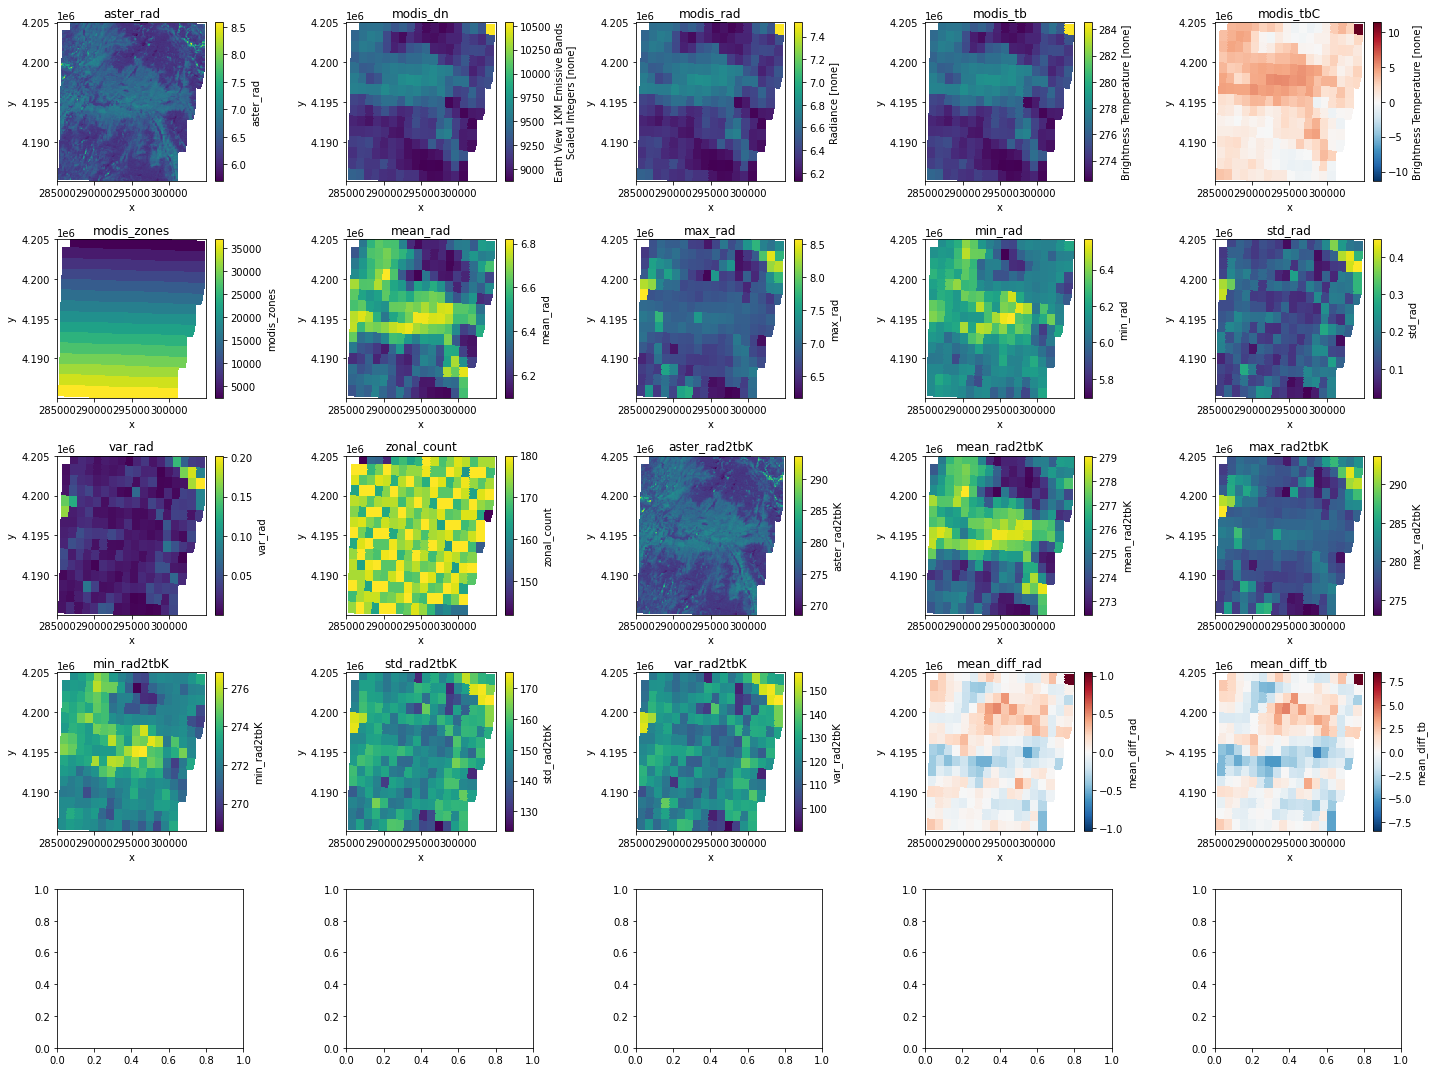

In [19]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20,15), tight_layout=True)
ax = ax.flatten()

for i, data_var in enumerate(ds):
    ds[str(data_var)].plot(ax=ax[i])
    ax[i].set_title(str(data_var))